In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Found 3588 image-mask pairs.
Training set: (2870, 256, 256, 3), (2870, 256, 256, 1)
Validation set: (359, 256, 256, 3), (359, 256, 256, 1)
Test set: (359, 256, 256, 3), (359, 256, 256, 1)


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:328: UserWarning: /kaggle/working/polyp_augmented_mask/augmented_mask_0.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:328: UserWarning: /kaggle/working/polyp_augmented_mask/augmented_mask_1.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:328: UserWarning: /kaggle/working/polyp_augmented_mask/augmented_mask_2.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:328: UserWarning: /kaggle/working/polyp_augmented_mask/augmented_mask_3.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:328: UserWarning: /kaggle/working/polyp_augmented_mask/augmented_mask_4.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/pytho

Final Training set: (17870, 256, 256, 3), (17870, 256, 256, 1)


<ipython-input-2-5e75e44b3574>:127: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(aug_x_train[0])
<ipython-input-2-5e75e44b3574>:130: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(aug_y_train[0, :, :, 0], cmap='gray')
/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


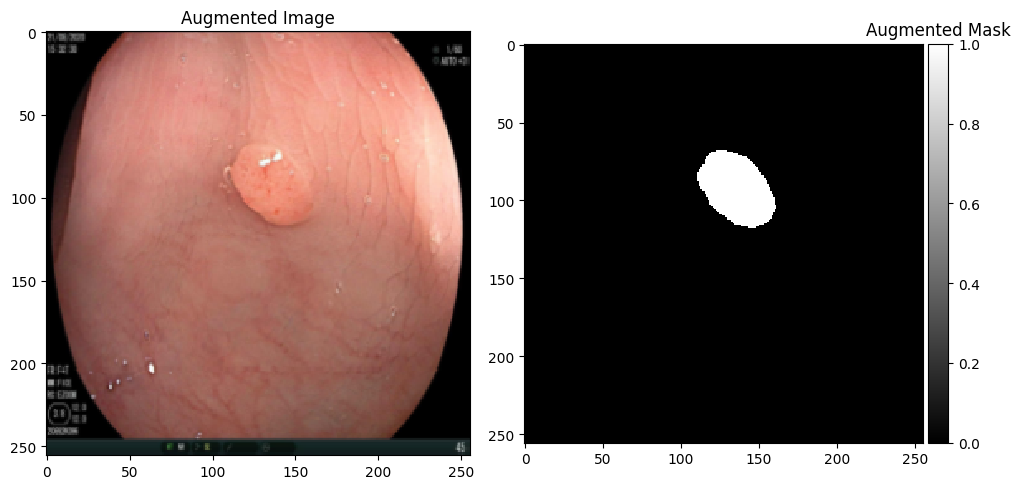

In [2]:
import os
import numpy as np
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A
import random

# Define dataset path
image_dir = '/kaggle/input/polydb/PolypDB/PolypDB_modality_wise/WLI/images'
mask_dir = '/kaggle/input/polydb/PolypDB/PolypDB_modality_wise/WLI/masks'

# Image parameters
# Image parameters
IMG_HEIGHT, IMG_WIDTH = 256, 256
CHANNELS = 3
TARGET_SIZE = 15000 #  # Augmented dataset size

# Get sorted file lists
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Check image-mask consistency
if len(image_files) != len(mask_files):
    print(f"Warning: Image-mask count mismatch. Images: {len(image_files)}, Masks: {len(mask_files)}")
else:
    print(f"Found {len(image_files)} image-mask pairs.")

def load_and_preprocess(index):
    """Load, resize, and preprocess an image-mask pair."""
    image_path = os.path.join(image_dir, image_files[index])
    mask_path = os.path.join(mask_dir, mask_files[index])

    image = imread(image_path)
    mask = imread(mask_path, as_gray=True)

    # Ensure correct shape (for RGBA images)
    if image.shape[-1] == 4:
        image = image[:, :, :3]

    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='reflect', anti_aliasing=True)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='reflect', anti_aliasing=True)

    # Convert mask to binary
    mask = (mask > 0.5).astype(np.uint8)

    return (image * 255).astype(np.uint8), mask

# Augmentation Pipelines (Reduced p values for better variation)
aug = A.Compose([
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Transpose(p=0.5),
    A.GridDistortion(p=0.3),  # Lowered probability
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5)  # Added color augmentation
])

# Augmented dataset directories
img_augmented_path = "/kaggle/working/polyp_augmented_image"
msk_augmented_path = "/kaggle/working/polyp_augmented_mask"

# Create directories if they don't exist
os.makedirs(img_augmented_path, exist_ok=True)
os.makedirs(msk_augmented_path, exist_ok=True)

# Load and preprocess images
all_x = []
all_y = []

for count in range(len(image_files)):
    x, y = load_and_preprocess(count)
    all_x.append(x)
    all_y.append(y)

# Convert lists to numpy arrays
all_x = np.array(all_x)
all_y = np.expand_dims(np.array(all_y), axis=-1)  # Add an extra dimension for the mask

# Split dataset (80% train, 10% val, 10% test)
x_train, x_temp, y_train, y_temp = train_test_split(all_x, all_y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset shapes
print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")

# Augment the training data (up to TARGET_SIZE)
aug_x_train = np.zeros((TARGET_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.uint8)
aug_y_train = np.zeros((TARGET_SIZE, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

for count in range(TARGET_SIZE):
    index = random.randint(0, len(x_train) - 1)
    image = x_train[index]
    mask = y_train[index, :, :, 0]

    # Augment the image and mask
    augmented = aug(image=image, mask=mask)
    aug_x_train[count] = augmented['image']
    aug_y_train[count, :, :, 0] = augmented['mask']

    # Optionally save augmented images and masks
    new_image_path = os.path.join(img_augmented_path, f"augmented_image_{count}.png")
    new_mask_path = os.path.join(msk_augmented_path, f"augmented_mask_{count}.png")

    imsave(new_image_path, aug_x_train[count])
    imsave(new_mask_path, aug_y_train[count, :, :, 0])
# Combine original and augmented data
final_x_train = np.concatenate((x_train, aug_x_train), axis=0)
final_y_train = np.concatenate((y_train, aug_y_train), axis=0)

# Print the new dataset size
print(f"Final Training set: {final_x_train.shape}, {final_y_train.shape}")

# Optionally shuffle the dataset
indices = np.arange(final_x_train.shape[0])
np.random.shuffle(indices)

final_x_train = final_x_train[indices]
final_y_train = final_y_train[indices]

# Display a sample image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(aug_x_train[0])
plt.title("Augmented Image")
plt.subplot(1, 2, 2)
imshow(aug_y_train[0, :, :, 0], cmap='gray')
plt.title("Augmented Mask")
plt.show()

In [3]:
# Print the shapes
print("final_x_train shape:", final_x_train.shape)
print("final_y_train shape:", final_y_train.shape)

final_x_train shape: (17870, 256, 256, 3)
final_y_train shape: (17870, 256, 256, 1)


In [4]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

""" Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLabV3Plus(shape):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = DeepLabV3Plus(input_shape)
    model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 17,830,209 (68.02 MB)

 Trainable params: 17,795,425 (67.88 MB)

 Non-trainable params: 34,784 (135.88 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, concatenate, GlobalAveragePooling2D, Dense, Reshape, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


def tversky_loss(y_true, y_pred, alpha=0.6, beta=0.4, epsilon=1e-6):
    # Flatten the input tensors
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    # True Positives (TP), False Positives (FP), False Negatives (FN)
    TP = tf.reduce_sum(y_true * y_pred)
    FP = tf.reduce_sum((1 - y_true) * y_pred)
    FN = tf.reduce_sum(y_true * (1 - y_pred))

    # Calculate the Tversky Index
    tversky_index = (TP + epsilon) / (TP + alpha * FP + beta * FN + epsilon)

    # Tversky Loss is the complement of the Tversky Index
    return 1 - tversky_index




# Loss and Metric Functions
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / (union + 1e-6)
    return 1 - iou

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    loss = alpha * tf.pow(1 - y_pred, gamma) * bce
    return loss



In [ ]:
def combo_loss(y_true, y_pred, dice_weight=0.3, bce_weight=0.2,iou_weight=0.2,tversky_weight=0.3, pos_weight=6.0, neg_weight=1.0):
    y_true = tf.cast(y_true, tf.float32)

    # Dice Loss
    dice = dice_loss(y_true, y_pred)

    # Binary Cross-Entropy (Weighted)
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    weighted_bce = pos_weight * y_true * bce + neg_weight * (1 - y_true) * bce

    # IoU Loss
    iou = iou_loss(y_true, y_pred)

    # Tversky Loss (For Imbalance)
    tversky = tversky_loss(y_true, y_pred)

    # Compute final loss with weights
    return (dice_weight * dice +
            bce_weight * tf.reduce_mean(weighted_bce) + iou_weight * iou + tversky_weight * tversky
            )

In [5]:

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam


# Define Adam optimizer with an initial learning rate
initial_lr = 1e-4
optimizer = Adam(learning_rate=initial_lr)


def lr_schedule(epoch, lr):
    if epoch < 5:  # Warmup phase
        return lr * 1.5  # Increase LR to stabilize training
    elif epoch < 30:
        return lr * 0.98  # Gradual decay
    else:
        return lr * 0.95  # Final stabilization

lr_scheduler = LearningRateScheduler(lr_schedule)

In [7]:
import tensorflow.keras.backend as K

smooth = 1


def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)
# Create the metric objects outside the functions
prec = tf.keras.metrics.Precision()
rec = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred):
    # Update states using the global metric objects
    prec.update_state(y_true, y_pred)
    rec.update_state(y_true, y_pred)

    p = prec.result()
    r = rec.result()

    # Reseting states for the next call
    prec.reset_state()
    rec.reset_state()

    return 2 * ((p * r) / (p + r + 1e-6))

def f2_score(y_true, y_pred):
    # Update states using the global metric objects
    prec.update_state(y_true, y_pred)
    rec.update_state(y_true, y_pred)

    p = prec.result()
    r = rec.result()

    # Reseting states for the next call
    prec.reset_state()
    rec.reset_state()

    return 5 * ((p * r) / ((4 * p) + r + 1e-6))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))  # Cast y_true to float32
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# In your model.compile call:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[iou,dice_coef, f1_score, f2_score, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=10,            # Stop if no improvement for 5 epochs
    restore_best_weights=True  # Restore best model weights
)

# Compile the model (assuming bce_dice_loss, iou, f1_score, etc., are defined)
# model.compile(optimizer=Adam(learning_rate=1e-4), loss=bce_dice_loss, metrics=[iou, f1_score, f2_score, Precision(), Recall()])

# Train the model with Early Stopping
history = model.fit(
    final_x_train, final_y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping,lr_scheduler]  # Add the Early Stopping callback
)

Epoch 1/50
2234/2234 ━━━━━━━━━━━━━━━━━━━━ 465s 182ms/step - dice_coef: 0.6687 - f1_score: 0.7794 - f2_score: 0.7678 - iou: 0.5183 - loss: 0.1114 - precision_3: 0.7977 - recall_3: 0.7464 - val_dice_coef: 0.7790 - val_f1_score: 0.8247 - val_f2_score: 0.7931 - val_iou: 0.6472 - val_loss: 0.0878 - val_precision_3: 0.9064 - val_recall_3: 0.7677 - learning_rate: 1.5000e-04
Epoch 2/50
2234/2234 ━━━━━━━━━━━━━━━━━━━━ 365s 164ms/step - dice_coef: 0.8071 - f1_score: 0.8735 - f2_score: 0.8702 - iou: 0.6820 - loss: 0.0575 - precision_3: 0.8971 - recall_3: 0.8561 - val_dice_coef: 0.8051 - val_f1_score: 0.8394 - val_f2_score: 0.8188 - val_iou: 0.6793 - val_loss: 0.0841 - val_precision_3: 0.8868 - val_recall_3: 0.7925 - learning_rate: 2.2500e-04
Epoch 3/50
2234/2234 ━━━━━━━━━━━━━━━━━━━━ 365s 163ms/step - dice_coef: 0.8152 - f1_score: 0.8772 - f2_score: 0.8739 - iou: 0.6936 - loss: 0.0557 - precision_3: 0.8995 - recall_3: 0.8620 - val_dice_coef: 0.7730 - val_f1_score: 0.8203 - val_f2_score: 0.7757 - va

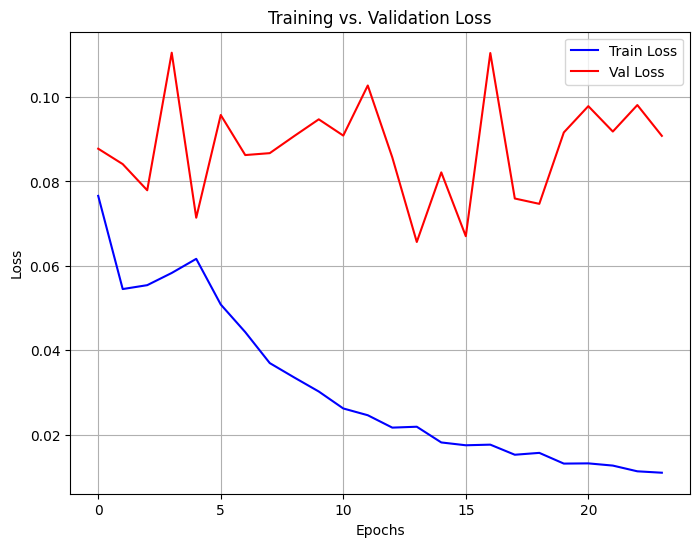

In [9]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
def plot_loss(history):
    plt.figure(figsize=(8, 6))

    # Plot training & validation loss
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='red')

    # Labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()

# Call the function after training
plot_loss(history)


In [10]:
y_pred = model.predict(x_test)  # Predict masks for test images


12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 527ms/step


In [12]:
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)  # Convert probability map to binary mask


In [13]:
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)
print("y_pred_thresholded shape:", y_pred_thresholded.shape)


x_test shape: (359, 256, 256, 3)
y_test shape: (359, 256, 256, 1)
y_pred shape: (359, 256, 256, 1)
y_pred_thresholded shape: (359, 256, 256, 1)


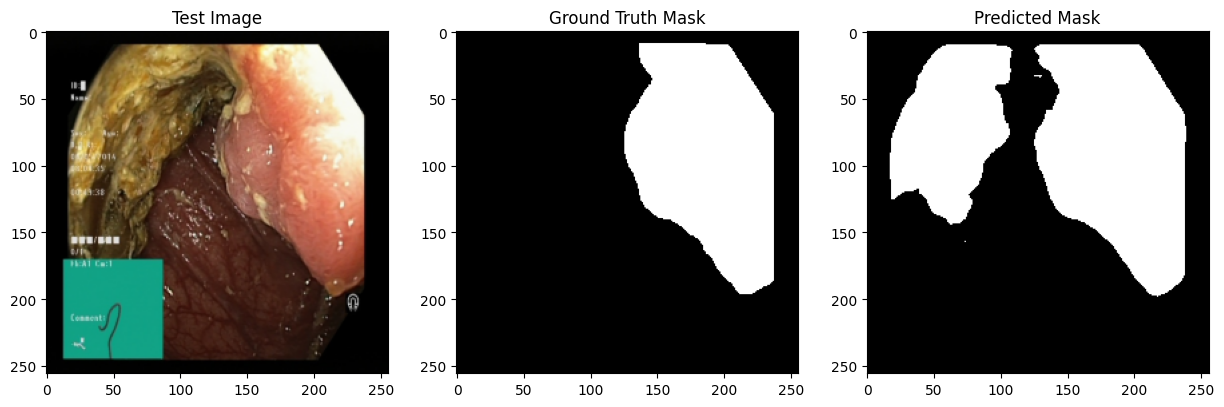

In [14]:
import matplotlib.pyplot as plt
import random

# Select a random test image
index = random.randint(0, len(x_test) - 1)

plt.figure(figsize=(15, 5))

# Original test image
plt.subplot(1, 3, 1)
plt.imshow(x_test[index])
plt.title("Test Image")

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(y_test[index, :, :, 0], cmap='gray')
plt.title("Ground Truth Mask")

# Predicted mask (thresholded)
plt.subplot(1, 3, 3)
plt.imshow(y_pred_thresholded[index, :, :, 0], cmap='gray')
plt.title("Predicted Mask")

plt.show()


In [15]:
import tensorflow as tf
import numpy as np

# Lists to store scores
dice_scores = []
iou_scores = []

# Initialize the Keras Precision and Recall metrics
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

# Loop through each test sample
for i in range(len(y_test)):
    # Convert to float32 before calculation
    y_true = y_test[i].astype(np.float32)
    y_pred = y_pred_thresholded[i].astype(np.float32)

    # Calculate Dice, IoU, Precision, and Recall for each sample
    dice = dice_coef(y_true, y_pred)
    iou_score = iou(y_true, y_pred)  # Assuming iou is your IoU function

    # Update the Precision and Recall metrics
    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)

    # Append scores
    dice_scores.append(dice)
    iou_scores.append(iou_score)

# Final Precision and Recall after iterating through all test samples
mean_precision = precision_metric.result().numpy()
mean_recall = recall_metric.result().numpy()

# Calculate mean scores
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

# Compute F1 and F2 scores
if mean_precision + mean_recall > 0:
    f1_score = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall)
    f2_score = 5 * (mean_precision * mean_recall) / (4 * mean_precision + mean_recall)
else:
    f1_score, f2_score = 0.0, 0.0  # Avoid division by zero

# Print results
print(f"Mean Dice Score: {mean_dice:.4f}")
print(f"Mean IoU Score: {mean_iou:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")


print(f"F1 Score: {f1_score:.4f}")
print(f"F2 Score: {f2_score:.4f}")


Mean Dice Score: 0.8548
Mean IoU Score: 0.7843
Mean Precision: 0.8928
Mean Recall: 0.8558
F1 Score: 0.8739
F2 Score: 0.8630


In [16]:
# =====================================================
# IMPORTS
# =====================================================
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

# =====================================================
# PARAMETERS
# =====================================================
THRESHOLD = 0.5
BASE_DIR = "/kaggle/working/visual"

IMG_DIR  = os.path.join(BASE_DIR, "images")
GT_DIR   = os.path.join(BASE_DIR, "ground_truth")
PRED_DIR = os.path.join(BASE_DIR, "predictions")
COMP_DIR = os.path.join(BASE_DIR, "comparisons")
CSV_FILE = os.path.join(BASE_DIR, "metrics.csv")

# Create directories
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(GT_DIR, exist_ok=True)
os.makedirs(PRED_DIR, exist_ok=True)
os.makedirs(COMP_DIR, exist_ok=True)

# =====================================================
# PREDICT & THRESHOLD
# =====================================================
y_pred = model.predict(x_test, batch_size=1, verbose=1)
y_pred_bin = (y_pred > THRESHOLD).astype(np.uint8)

# =====================================================
# INITIALIZE CSV
# =====================================================
with open(CSV_FILE, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "Image_Index",
        "Precision",
        "Recall",
        "F2",
        "Dice",
        "IoU"
    ])

# =====================================================
# METRIC FUNCTION
# =====================================================
def compute_metrics(y_true, y_pred):
    y_true = y_true.astype(np.uint8)
    y_pred = y_pred.astype(np.uint8)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    precision = TP / (TP + FP + 1e-6)
    recall    = TP / (TP + FN + 1e-6)
    f2        = 5 * precision * recall / (4 * precision + recall + 1e-6)
    dice      = 2 * TP / (2 * TP + FP + FN + 1e-6)
    iou       = TP / (TP + FP + FN + 1e-6)

    return precision, recall, f2, dice, iou

# =====================================================
# METRICS STORAGE FOR MEAN
# =====================================================
dice_scores = []
iou_scores  = []
precision_metric = tf.keras.metrics.Precision()
recall_metric    = tf.keras.metrics.Recall()

# =====================================================
# LOOP THROUGH ALL TEST IMAGES
# =====================================================
for i in range(len(x_test)):

    # ------------------- DATA -------------------
    img  = x_test[i]
    gt   = y_test[i, :, :, 0].astype(np.uint8)
    pred = y_pred_bin[i, :, :, 0].astype(np.uint8)

    # ------------------- METRICS -------------------
    precision, recall, f2, dice, iou = compute_metrics(gt, pred)

    # Update metrics for mean
    dice_scores.append(dice)
    iou_scores.append(iou)
    precision_metric.update_state(gt, pred)
    recall_metric.update_state(gt, pred)

    # ------------------- SAVE CSV -------------------
    with open(CSV_FILE, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([i+1, precision, recall, f2, dice, iou])

    # ------------------- SAVE IMAGES -------------------
    plt.imsave(os.path.join(IMG_DIR, f"image_{i+1}.png"), img)
    plt.imsave(os.path.join(GT_DIR, f"gt_{i+1}.png"), gt, cmap='gray')
    plt.imsave(os.path.join(PRED_DIR, f"pred_{i+1}.png"), pred, cmap='gray')

    # ------------------- DISPLAY COMPARISON -------------------

# =====================================================
# FINAL MEAN METRICS
# =====================================================
mean_precision = precision_metric.result().numpy()
mean_recall    = recall_metric.result().numpy()
mean_dice      = np.mean(dice_scores)
mean_iou       = np.mean(iou_scores)
mean_f2        = 5 * mean_precision * mean_recall / (4 * mean_precision + mean_recall + 1e-6)

print("========== FINAL RESULTS ==========")
print(f"Mean Dice       : {mean_dice:.4f}")
print(f"Mean IoU        : {mean_iou:.4f}")
print(f"Mean Precision  : {mean_precision:.4f}")
print(f"Mean Recall     : {mean_recall:.4f}")
print(f"Mean F2 Score   : {mean_f2:.4f}")

print(f"\nAll results saved in: {BASE_DIR}")
print(f"CSV metrics saved as: {CSV_FILE}")


359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
========== FINAL RESULTS ==========
Mean Dice       : 0.8548
Mean IoU        : 0.7843
Mean Precision  : 0.8928
Mean Recall     : 0.8558
Mean F2 Score   : 0.8630

All results saved in: /kaggle/working/visual
CSV metrics saved as: /kaggle/working/visual/metrics.csv


In [17]:
import pandas as pd
import numpy as np

# =====================================================
# CALCULATE POLYP AREA RATIO FOR EACH PREDICTED MASK
# =====================================================
areas = [np.sum(y_pred_thresholded[i]) / (y_pred_thresholded[i].shape[0]*y_pred_thresholded[i].shape[1])
         for i in range(len(y_pred_thresholded))]

# =====================================================
# DEFINE SIZE THRESHOLDS (ADAPTIVE)
# =====================================================
small_thr = np.percentile(areas, 25)
medium_thr = np.percentile(areas, 75)

def polyp_size(area):
    if area <= small_thr:
        return "Small"
    elif area <= medium_thr:
        return "Medium"
    else:
        return "Large"

size_labels = [polyp_size(a) for a in areas]

# =====================================================
# CREATE DATAFRAME WITH METRICS
# =====================================================
df = pd.DataFrame({
    "Dice": dice_scores,
    "IoU": iou_scores,
    "Precision": [mean_precision]*len(dice_scores),  # or use per-image Precision if available
    "Recall": [mean_recall]*len(dice_scores),        # or per-image Recall if available
    "F1": [f1_score]*len(dice_scores),
    "F2": [f2_score]*len(dice_scores),
    "Area_Ratio": areas,
    "Polyp_Size": size_labels
})

# =====================================================
# SAVE CSVs PER SIZE
# =====================================================
CSV_DIR = "/kaggle/working/metrics_by_size"
os.makedirs(CSV_DIR, exist_ok=True)

for size in ["Small", "Medium", "Large"]:
    df_size = df[df["Polyp_Size"] == size]
    df_size.to_csv(f"{CSV_DIR}/{size.lower()}_metrics.csv", index=False)

# =====================================================
# COMPUTE MEAN METRICS PER SIZE
# =====================================================
mean_metrics_by_size = df.groupby("Polyp_Size")[["Dice","IoU","Precision","Recall","F1","F2"]].mean()
print("========== MEAN METRICS PER POLYP SIZE ==========")
print(mean_metrics_by_size)


========== MEAN METRICS PER POLYP SIZE ==========
                Dice       IoU  Precision    Recall       F1        F2
Polyp_Size                                                            
Large       0.880271  0.821132   0.892784  0.855818  0.87391  0.862964
Medium      0.874178  0.803847   0.892784  0.855818  0.87391  0.862964
Small       0.790650  0.708473   0.892784  0.855818  0.87391  0.862964


In [18]:
import zipfile
import os

# Directory where the per-size CSVs are saved
CSV_DIR = "/kaggle/working/metrics_by_size"

# Output zip file
zip_filename = "/kaggle/working/polyp_metrics_by_size.zip"

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(CSV_DIR):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                zipf.write(file_path, arcname=file)  # arcname avoids nested folders

print(f"All per-size CSVs zipped into: {zip_filename}")


All per-size CSVs zipped into: /kaggle/working/polyp_metrics_by_size.zip


In [19]:

import shutil

# Folder you want to zip
folder_to_zip = "/kaggle/working/visual"

# Output zip file path
output_zip = "/kaggle/working/visual.zip"

# Create the zip file
shutil.make_archive(base_name=output_zip.replace(".zip",""), format='zip', root_dir=folder_to_zip)

print(f"✅ Zipped folder saved as: {output_zip}")


✅ Zipped folder saved as: /kaggle/working/visual.zip


In [20]:
model.save('/kaggle/working/ourmodel1.h5')


Small polyps: 90, Medium polyps: 179, Large polyps: 90


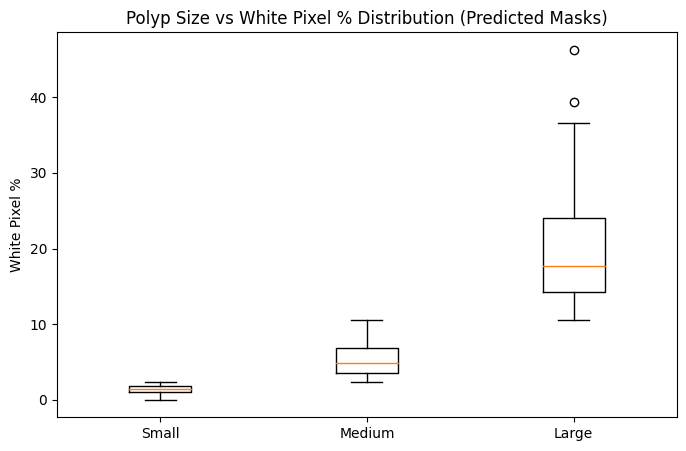

In [21]:

# ======================================================
# WHITE PIXEL ANALYSIS
# ======================================================
def white_pixel_percentage(mask):
    return (np.sum(mask == 1) / mask.size) * 100

white_per_test_image = [white_pixel_percentage(y_pred_bin[i, :, :, 0]) for i in range(len(y_pred_bin))]

# ======================================================
# CLASSIFY POLYPS BY SIZE (ADAPTIVE)
# ======================================================
areas = [np.sum(mask) / (mask.shape[0]*mask.shape[1]) for mask in y_pred_bin]

small_thr  = np.percentile(areas, 25)
medium_thr = np.percentile(areas, 75)

def polyp_size_adaptive(area):
    if area <= small_thr:
        return "Small"
    elif area <= medium_thr:
        return "Medium"
    else:
        return "Large"

size_labels = [polyp_size_adaptive(a) for a in areas]

small_idx  = [i for i, s in enumerate(size_labels) if s == "Small"]
medium_idx = [i for i, s in enumerate(size_labels) if s == "Medium"]
large_idx  = [i for i, s in enumerate(size_labels) if s == "Large"]

print(f"Small polyps: {len(small_idx)}, Medium polyps: {len(medium_idx)}, Large polyps: {len(large_idx)}")

# ======================================================
# OPTIONAL: BOX PLOT OF WHITE PIXEL % PER SIZE
# ======================================================
small_values  = [white_per_test_image[i] for i in small_idx]
medium_values = [white_per_test_image[i] for i in medium_idx]
large_values  = [white_per_test_image[i] for i in large_idx]

plt.figure(figsize=(8,5))
plt.boxplot([small_values, medium_values, large_values], labels=["Small", "Medium", "Large"])
plt.ylabel("White Pixel %")
plt.title("Polyp Size vs White Pixel % Distribution (Predicted Masks)")
plt.show()

In [22]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score
import tensorflow.keras.backend as K

# ======================================================
# DICE AND IoU FUNCTIONS
# ======================================================
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# ======================================================
# COMPUTE METRICS FOR ONE SAMPLE
# ======================================================
def compute_metrics(y_true, y_pred):
    dice = dice_coef(y_true, y_pred).numpy()  # convert from tensor to float
    iou_score = iou(y_true, y_pred).numpy()
    precision = precision_score(y_true.flatten(), y_pred.flatten())
    recall = recall_score(y_true.flatten(), y_pred.flatten())
    
    return {
        "Dice": dice,
        "IoU": iou_score,
        "Precision": precision,
        "Sensitivity": recall
    }

# ======================================================
# COMPUTE METRICS FOR A POLYP SIZE GROUP
# ======================================================
def metrics_by_group(indices, group_name):
    dice_list = []
    iou_list  = []
    prec_list = []
    rec_list  = []
    f2_list   = []

    for i in indices:
        # Ensure float32 input for dice/iou
        y_true = y_test[i, :, :, 0].astype(np.float32)
        y_pred = y_pred_bin[i, :, :, 0].astype(np.float32)
        
        metrics = compute_metrics(y_true, y_pred)
        
        dice_list.append(metrics["Dice"])
        iou_list.append(metrics["IoU"])
        prec_list.append(metrics["Precision"])
        rec_list.append(metrics["Sensitivity"])
        
        # Compute F2 score
        P = metrics["Precision"]
        R = metrics["Sensitivity"]
        f2 = 5 * (P * R) / (4*P + R) if (4*P + R) > 0 else 0.0
        f2_list.append(f2)

    print(f"=== {group_name} Polyps ===")
    print(f"Count: {len(indices)}")
    print(f"Mean Dice      : {np.mean(dice_list):.4f}")
    print(f"Mean IoU       : {np.mean(iou_list):.4f}")
    print(f"Mean Precision : {np.mean(prec_list):.4f}")
    print(f"Mean Recall    : {np.mean(rec_list):.4f}")
    print(f"Mean F2 Score  : {np.mean(f2_list):.4f}\n")
    
    return {
        "Dice": dice_list,
        "IoU": iou_list,
        "Precision": prec_list,
        "Recall": rec_list,
        "F2": f2_list
    }

# ======================================================
# COMPUTE METRICS FOR SMALL, MEDIUM, LARGE
# ======================================================
small_metrics  = metrics_by_group(small_idx, "Small")
medium_metrics = metrics_by_group(medium_idx, "Medium")
large_metrics  = metrics_by_group(large_idx, "Large")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=== Small Polyps ===
Count: 90
Mean Dice      : 0.7906
Mean IoU       : 0.7085
Mean Precision : 0.8621
Mean Recall    : 0.7840
Mean F2 Score  : 0.7828

=== Medium Polyps ===
Count: 179
Mean Dice      : 0.8742
Mean IoU       : 0.8038
Mean Precision : 0.8981
Mean Recall    : 0.8826
Mean F2 Score  : 0.8748

=== Large Polyps ===
Count: 90
Mean Dice      : 0.8803
Mean IoU       : 0.8211
Mean Precision : 0.8955
Mean Recall    : 0.9104
Mean F2 Score  : 0.8881



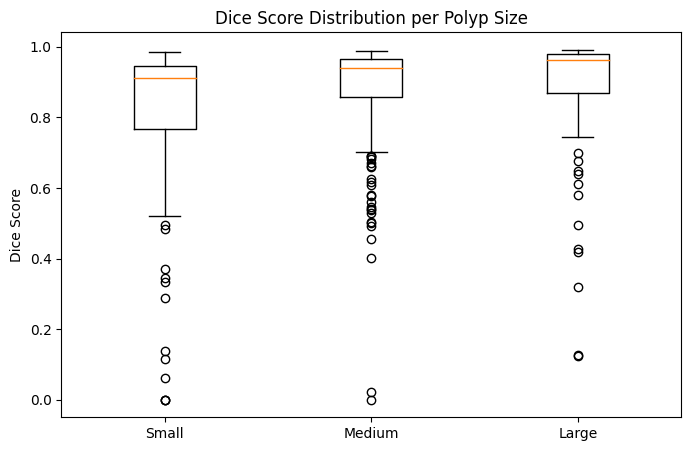

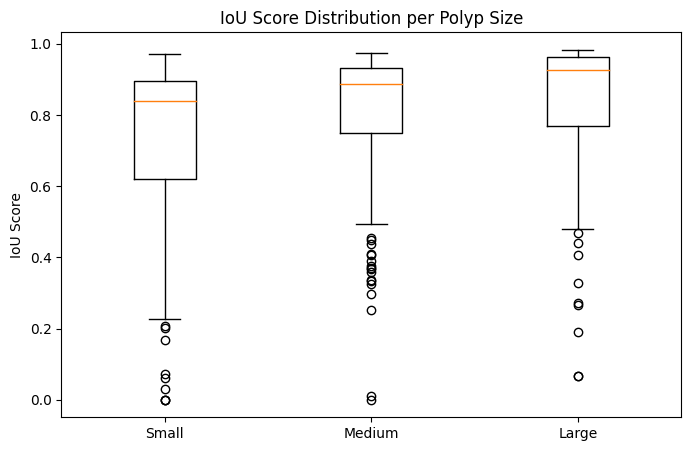

In [23]:
# ======================================================
# BOX PLOT OF DICE SCORES PER POLYP SIZE
# ======================================================
plt.figure(figsize=(8,5))
plt.boxplot([small_metrics["Dice"], medium_metrics["Dice"], large_metrics["Dice"]],
            labels=["Small", "Medium", "Large"])
plt.ylabel("Dice Score")
plt.title("Dice Score Distribution per Polyp Size")
plt.show()

# Optional: Also show IoU distribution
plt.figure(figsize=(8,5))
plt.boxplot([small_metrics["IoU"], medium_metrics["IoU"], large_metrics["IoU"]],
            labels=["Small", "Medium", "Large"])
plt.ylabel("IoU Score")
plt.title("IoU Score Distribution per Polyp Size")
plt.show()


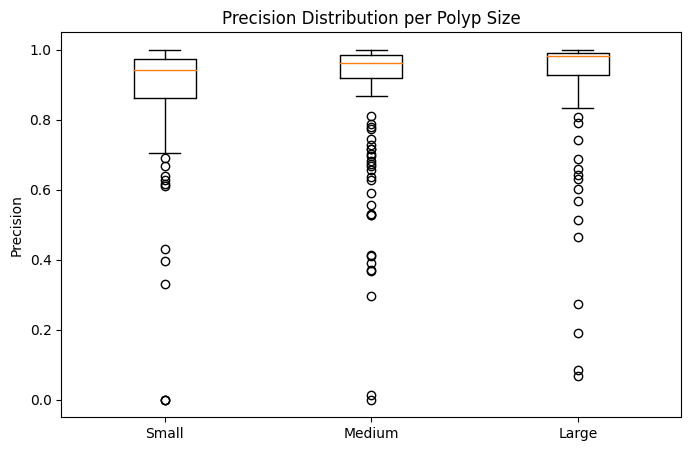

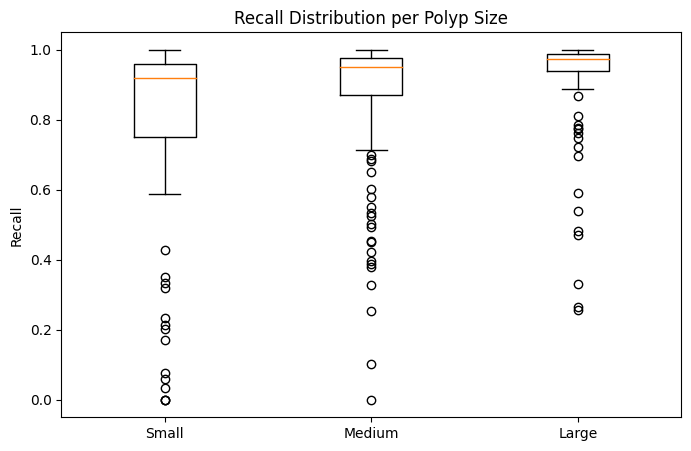

In [24]:
# ======================================================
# BOX PLOT OF PRECISION SCORES PER POLYP SIZE
# ======================================================
plt.figure(figsize=(8,5))
plt.boxplot([small_metrics["Precision"], medium_metrics["Precision"], large_metrics["Precision"]],
            labels=["Small", "Medium", "Large"])
plt.ylabel("Precision")
plt.title("Precision Distribution per Polyp Size")
plt.show()

# ======================================================
# BOX PLOT OF RECALL SCORES PER POLYP SIZE
# ======================================================
plt.figure(figsize=(8,5))
plt.boxplot([small_metrics["Recall"], medium_metrics["Recall"], large_metrics["Recall"]],
            labels=["Small", "Medium", "Large"])
plt.ylabel("Recall")
plt.title("Recall Distribution per Polyp Size")
plt.show()

# ======================================================



In [25]:
# ======================================================
# COMPUTE F2 SCORE PER IMAGE (ADD TO METRICS DICT)
# ======================================================
beta = 2
eps = 1e-6

for metrics in [small_metrics, medium_metrics, large_metrics]:
    metrics["F2"] = [
        (1 + beta**2) * p * r / (beta**2 * p + r + eps)
        for p, r in zip(metrics["Precision"], metrics["Recall"])
    ]


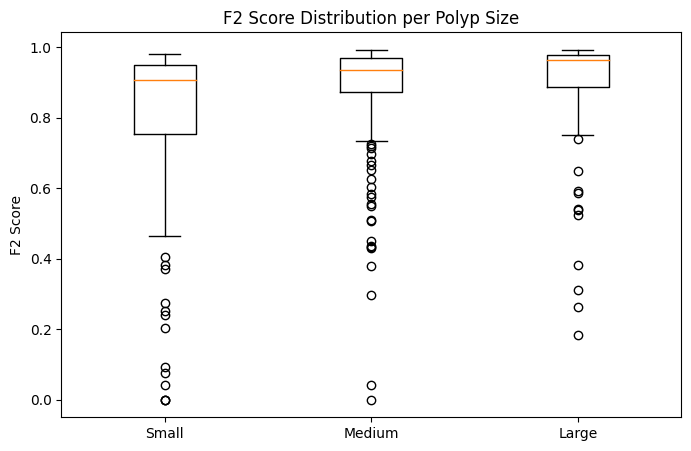

In [26]:
# ======================================================
# BOX PLOT OF F2 SCORES PER POLYP SIZE
# ======================================================
plt.figure(figsize=(8,5))
plt.boxplot(
    [small_metrics["F2"], medium_metrics["F2"], large_metrics["F2"]],
    labels=["Small", "Medium", "Large"]
)
plt.ylabel("F2 Score")
plt.title("F2 Score Distribution per Polyp Size")
plt.show()


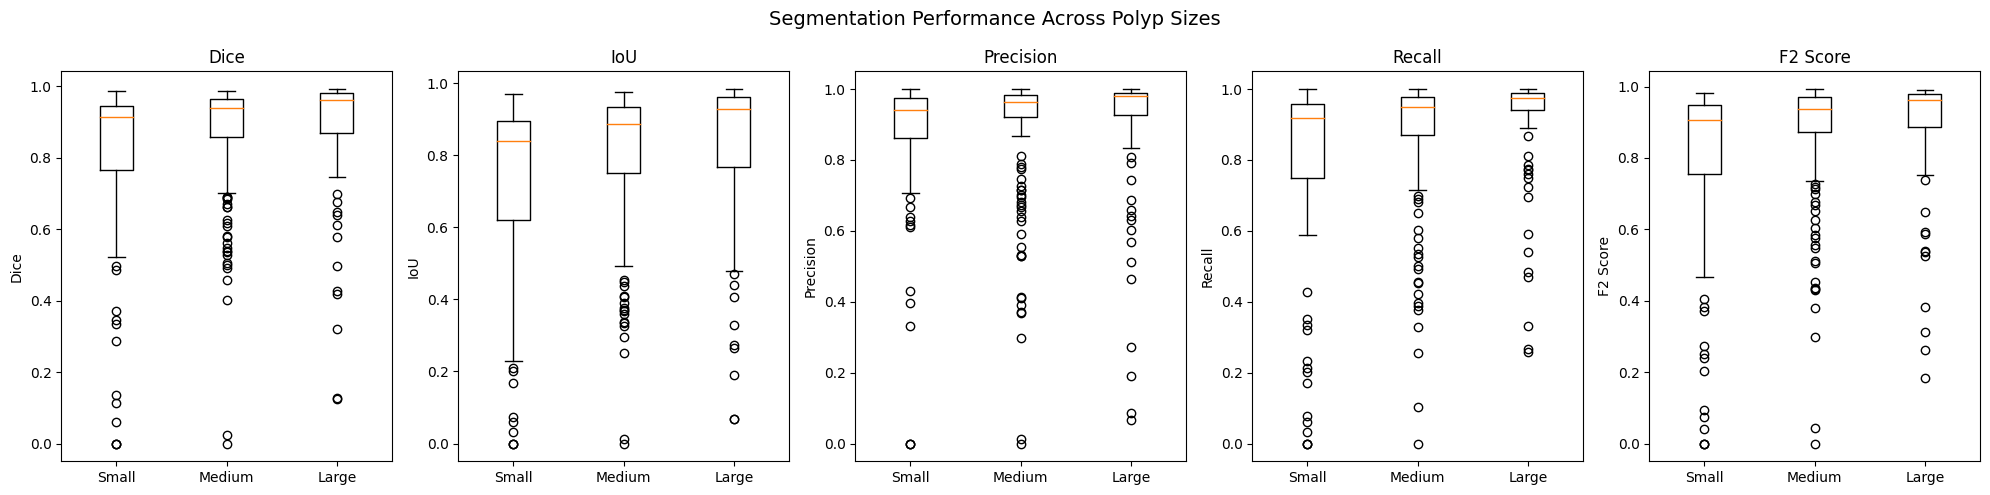

In [27]:
plt.figure(figsize=(20,5))

metrics = ["Dice", "IoU", "Precision", "Recall", "F2"]
titles  = ["Dice", "IoU", "Precision", "Recall", "F2 Score"]

for i, (m, t) in enumerate(zip(metrics, titles), 1):
    plt.subplot(1, 5, i)
    plt.boxplot(
        [small_metrics[m], medium_metrics[m], large_metrics[m]],
        labels=["Small", "Medium", "Large"]
    )
    plt.ylabel(t)
    plt.title(t)

plt.suptitle("Segmentation Performance Across Polyp Sizes", fontsize=14)
plt.tight_layout()
plt.show()


In [28]:
import os
import matplotlib.pyplot as plt
import zipfile

# ======================================================
# CONFIG
# ======================================================
plot_dir = "/kaggle/working/plot"
os.makedirs(plot_dir, exist_ok=True)

metrics = {
    "Dice": "Dice Score",
    "IoU": "IoU Score",
    "Precision": "Precision",
    "Recall": "Recall",
    "F2": "F2 Score"
}

# ======================================================
# SAVE INDIVIDUAL METRIC PLOTS
# ======================================================
for metric, ylabel in metrics.items():
    plt.figure(figsize=(8,5))
    plt.boxplot(
        [small_metrics[metric], medium_metrics[metric], large_metrics[metric]],
        labels=["Small", "Medium", "Large"]
    )
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} Distribution per Polyp Size")
    
    save_path = os.path.join(plot_dir, f"{metric.lower()}_boxplot.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()


In [29]:
# ======================================================
# SAVE COMBINED METRIC PLOT
# ======================================================
plt.figure(figsize=(20,5))

metrics_list = ["Dice", "IoU", "Precision", "Recall", "F2"]
titles = ["Dice", "IoU", "Precision", "Recall", "F2 Score"]

for i, (m, t) in enumerate(zip(metrics_list, titles), 1):
    plt.subplot(1, 5, i)
    plt.boxplot(
        [small_metrics[m], medium_metrics[m], large_metrics[m]],
        labels=["Small", "Medium", "Large"]
    )
    plt.ylabel(t)
    plt.title(t)

plt.suptitle("Segmentation Performance Across Polyp Sizes", fontsize=14)
plt.tight_layout()

combined_path = os.path.join(plot_dir, "combined_metrics_boxplot.png")
plt.savefig(combined_path, dpi=300, bbox_inches="tight")
plt.close()


In [30]:
zip_filename = "/kaggle/working/plot.zip"

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(plot_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=file)

print("✅ All plots saved and zipped:")
print(zip_filename)


✅ All plots saved and zipped:
/kaggle/working/plot.zip
